# Kendrick Mass Filter 
 __Authors:__ Ricardo R. da Silva (ridasilva@ucsd.edu), Madeleine Ernst (mernst@ucsd.edu), Alan K. Jarmusch (ajarmusch@ucsd.edu) <br>
 __Verion:__ 1.0 (Prior to Submission of Manuscript) <br>
 __Date of Last Revision:__ 06-21-2018 <br>
 
**Description**: Kendrick mass is the mass-to-charge (*m/z*) of each ion rescaled to an integer value of a given unit repeat. The defect between the Kendrick scaled *m/z* and the integer Kendrick mass value, i.e. Kendrick mass defect (KMD), is similar between homologous compounds. The Kendrick Mass Filter (MDF) is used to perform selection and removal of data centered around a user-defined KMD, with addtional restrictions on the elution time and presence of possibly multiple homologous compounds eluting together. This notebook calculates and visualizes data output obtained through the Kendrick Mass Filter for a selected dataset using user-defined parameters.

**Input**: <br>
<ul>
<li>**Feature table**: (.csv) file with MS features in columns and samples in rows. Feature IDs are provided in the column names in the following format: "mz;RT". The first column must contain sample names. </li>
</ul> <br>
**Output**: <br>
<ul>
<li>**Summary tables**: (.csv) files containing Kendrick mass filtered output data. </li>
<li>**Plots** (.pdf): Kendrick mass plot, MS1 features plot and spectra before and after applying KMF.</li>
</ul> <br> 
**Dependencies**: R version 3.4.2 (2017-09-28) and packages: tidyr_0.8.0, dplyr_0.7.4, gridExtra_2.3, gtable_0.2.0, Rgraphviz_2.22.0, graph_1.56.0, BiocGenerics_0.24.0, Hmisc_4.0-3, ggplot2_2.2.1, Formula_1.2-2, survival_2.41-3, lattice_0.20-35 

load libraries

In [2]:
library(Hmisc)
library(Rgraphviz)
library(graph)
library(ggplot2)
library(gtable)
library(grid)
library(gridExtra)
library(dplyr)
library(tidyr)

library(partitions)
library(rgl)

load Kendrick Mass Filter source function

In [3]:
source("kendrick.mass.filter_new_all_datamatrix_terminologyupdate.R")

# Data Input and Preparation for Kendrick Mass Filter

load data matrix (samples in rows and variables in columns)

In [4]:
data_matrix <- read.csv("all17K/tab17PEG.csv", header=T, check.names=F)
head(data_matrix)

SAMPLE,432.281884626908;2.53300454545454,476.305215199788;2.6522125,388.253383000691;2.37624166666666,520.333179050021;2.75036574074074,415.252231763756;2.53302173913043,344.228422164916;2.14777916666666,371.22840590704;2.37920158730158,459.281274159749;2.65194375,503.303718898607;2.75060072463768,⋯,402.770065307617;3.13023333333333,202.109008789062;10.37515,123.091598510742;10.1250166666666,391.201583862304;2.37786666666666,153.137969970703;8.26475,667.394714355468;2.99201666666666,407.222579956054;2.68493333333333,724.43359375;3.28585,219.17446899414;5.62343333333333,130.966156005859;1.47876666666666
20170728_MS1_17k_PEG_1,6429624506,5408429283,7514160792,4055533016,3666656651,8277896112,3977181472,2950759341,1904767377,⋯,2223329,7827148,50427613,810762,53314268,1399198,1189306,1661110,1181526,28890918
20170728_MS1_17k_PEG_2,6617665352,5505775209,7571515869,4112716607,3882034452,8206703134,0,2955649147,1960552584,⋯,0,0,0,0,0,0,0,0,0,0
20170728_MS1_17k_PEG_3,6576928427,5625211740,7567208669,4159129490,3816859834,8316890279,4083276215,3003420137,1917175859,⋯,0,0,0,0,0,0,0,0,0,0


Prepare data for Kendrick Mass Filter: create a matrix containing one column with *m/z* values and another column with RT values and intensity, used by the gaussian filter.

In [5]:
vec <- do.call(rbind,lapply(strsplit(colnames(data_matrix)[2:ncol(data_matrix)],";"),matrix,ncol=2,byrow=TRUE))
class(vec) <- "numeric"
colnames(vec)<- c("mz","rt")

vec <- cbind(vec, t(data_matrix[1,-1]))
colnames(vec)[3] <- 'int'

head(vec)

,mz,rt,int
432.281884626908;2.53300454545454,432.2819,2.533005,6429624506
476.305215199788;2.6522125,476.3052,2.652213,5408429283
388.253383000691;2.37624166666666,388.2534,2.376242,7514160792
520.333179050021;2.75036574074074,520.3332,2.750366,4055533016
415.252231763756;2.53302173913043,415.2522,2.533022,3666656651
344.228422164916;2.14777916666666,344.2284,2.147779,8277896112


In [6]:
dim(vec)

[1] 429   3

# Apply Kendrick Mass Filter to data - extended
Parameters, which can be specified when running the mass filter: <br>
1. __Kendrick mass defect (KMD) [Da]__ - tolerance of mass defect. Smaller values result in a more stingent homology parameter. <br>
2. __Retention time (RT) [min]__ - tolerance for chromatographic elution. <br>
3. __Number of Observations (NOS)__ - how many oligomer peaks must be observed. Larger values result in more specificity. 
4. __connection_filter__ must be set to "TRUE" for NOS parameter to function correctly. <br>
5. __polymer__ - selection of polymers or signals to filter, options are:<br>
alkane_other_CH2, oxidation, water_cluster, alkane_C2H4, methanol_cluster, acetonitrile_cluster, propylation_other_C3H6, polyethylene_glycol_other_C2H4O1, perfluoro_CF2, ammoniumchloride_cluster, butylation_other_C4H8, sodiumchloride_cluster, polypropylene_glycol_other_C3H6O1, ammoniumformate_cluster, sodiumformate_cluster, potassiumchloride_cluster, polysiloxane, <br> sodiumacetate_cluster
6. __filterShape__ - find sequence of peaks with fixed proportional difference (default 0.6) that contain a single maximum
7. __fractionBase__ - Base used to divide the polymer unit base

run the Kendrick Mass Filter with user-specified parameters

In [7]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE,
    filterShape=TRUE,
    fractionBase=1
)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 6”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 6”

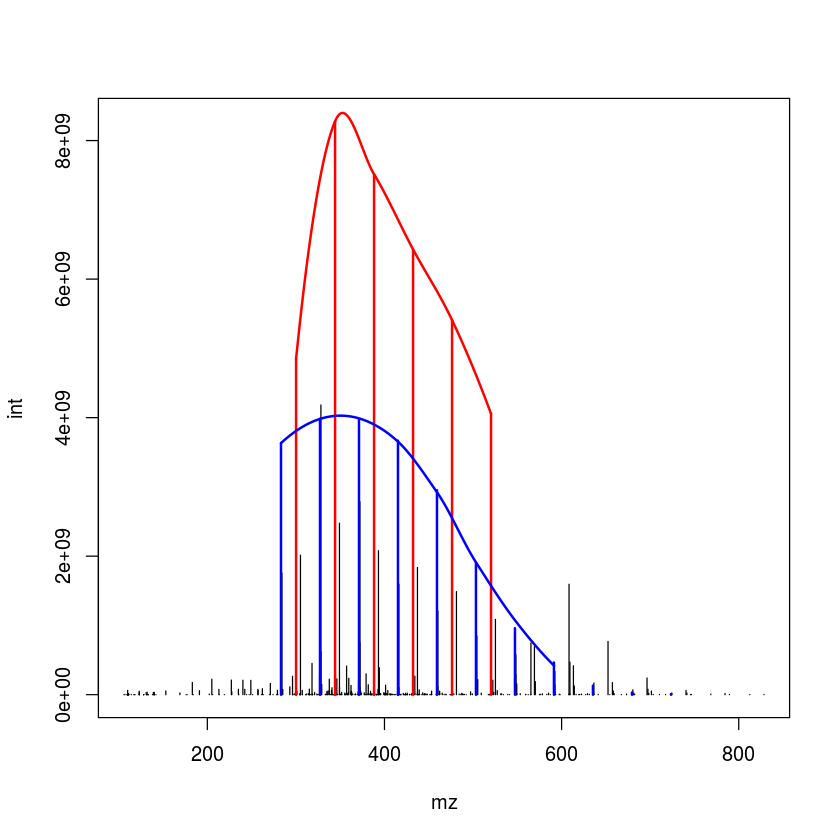

In [8]:
# Plot shape filter

# connected peaks detected by KMD
comp <- output$conn
# selection of the pattern deteced by filterShape
filt <- output$filt


plot(vec[,-2], type='h')
points(vec[as.numeric(comp[[1]]),-2], type='h', col=2, lwd=2)

y <- vec[as.numeric(comp[[1]])[filt[[1]]],3]
x <- vec[as.numeric(comp[[1]])[filt[[1]]],1]

# Fit a polynomial curve for points of the interval
# with the pattern interval
xl <- seq(min(x),max(x), (max(x) - min(x))/1000)
lo <- loess(y~x)
lines(xl, predict(lo,xl), col='red', lwd=2)

points(vec[as.numeric(comp[[2]]),-2], type='h', col=4, lwd=2)
y <- vec[as.numeric(comp[[2]])[filt[[2]]],3]
x <- vec[as.numeric(comp[[2]])[filt[[2]]],1]
xl <- seq(min(x),max(x), (max(x) - min(x))/1000)
lo <- loess(y~x)
lines(xl, predict(lo,xl), col='blue', lwd=2)

In [9]:
# keep rgl from plotting on the screen
save <- getOption("rgl.useNULL")
options(rgl.useNULL=TRUE)

In [10]:
# repeat the plot above in three dimensions
# the retention time dimension should allow
# the detection of peaks that selected by KMD
# that do not fit the curve
plot3d(vec,  type='h')
tmp <- vec[as.numeric(comp[[1]]),]
for(i in 1:nrow(tmp)) {
    segments3d(matrix(c(tmp[i,1:2], 0, tmp[i,]), ncol=3, byrow=TRUE), col=2, lwd=3)
}
spheres3d(vec[as.numeric(comp[[1]])[filt[[1]]],], radius=50000000, col=2)
y <- vec[as.numeric(comp[[1]])[filt[[1]]],3]                                                             
x <- vec[as.numeric(comp[[1]])[filt[[1]]],1]                                                             
xl <- seq(min(x),max(x), (max(x) - min(x))/1000)                                                          
lo <- loess(y~x)                                                                                          
z <- vec[as.numeric(comp[[1]])[filt[[1]]],2]
# loop over retention time and generate points
zl <- seq(min(z),max(z), (max(z) - min(z))/1000)
lines3d(xl, zl, predict(lo,xl), col='red', lwd=5)

# Save html file
filename <- writeWebGL(dir = ".", filename ="peakshape.html", width = 500, reuse = TRUE)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 6”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 6”

Warning message in convertScene(width = width, height = height, elementId = elementId, :
“Can't take snapshot with NULL rgl device”

In [11]:
IRdisplay::display_html('<iframe src="./peakshape.html" width=1000, height=1000></iframe> ')

In [12]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE,
    filterShape=TRUE,
    fractionBase=2
)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 357.02”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 22.233”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 494.36”

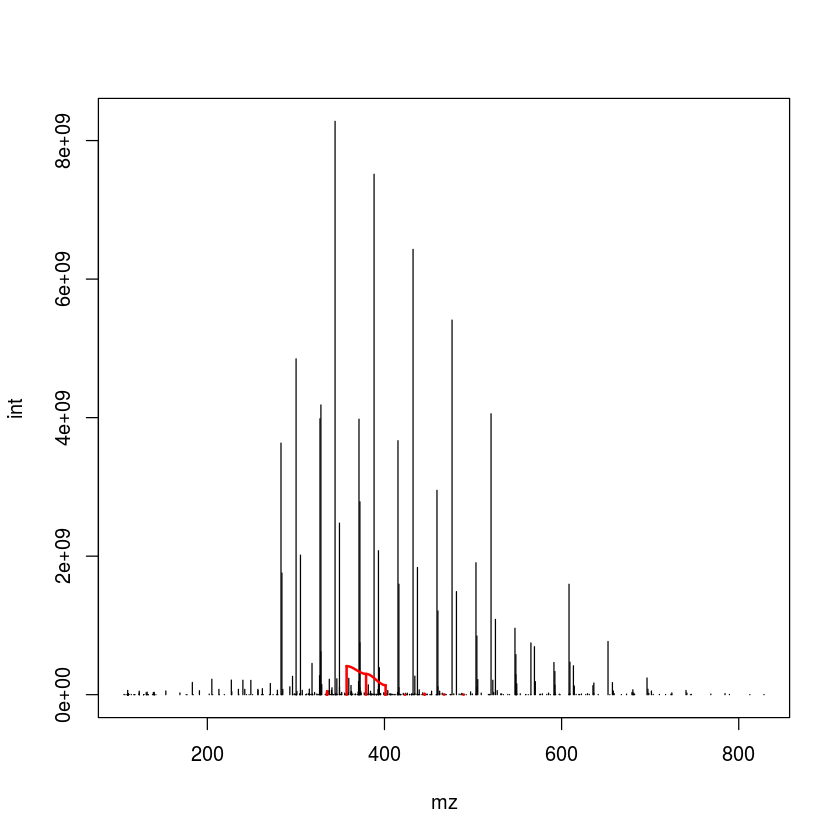

In [13]:
# Plot shape filter

# connected peaks detected by KMD
comp <- output$conn
# selection of the pattern deteced by filterShape
filt <- output$filt

plot(vec[,-2], type='h')
points(vec[as.numeric(comp[[3]]),-2], type='h', col=2, lwd=2)

y <- vec[as.numeric(comp[[3]])[filt[[3]]],3]
x <- vec[as.numeric(comp[[3]])[filt[[3]]],1]

# Fit a polynomial curve for points of the interval
# with the pattern interval
xl <- seq(min(x),max(x), (max(x) - min(x))/1000)
lo <- loess(y~x)
lines(xl, predict(lo,xl), col='red', lwd=2)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 357.02”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 22.233”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 494.36”

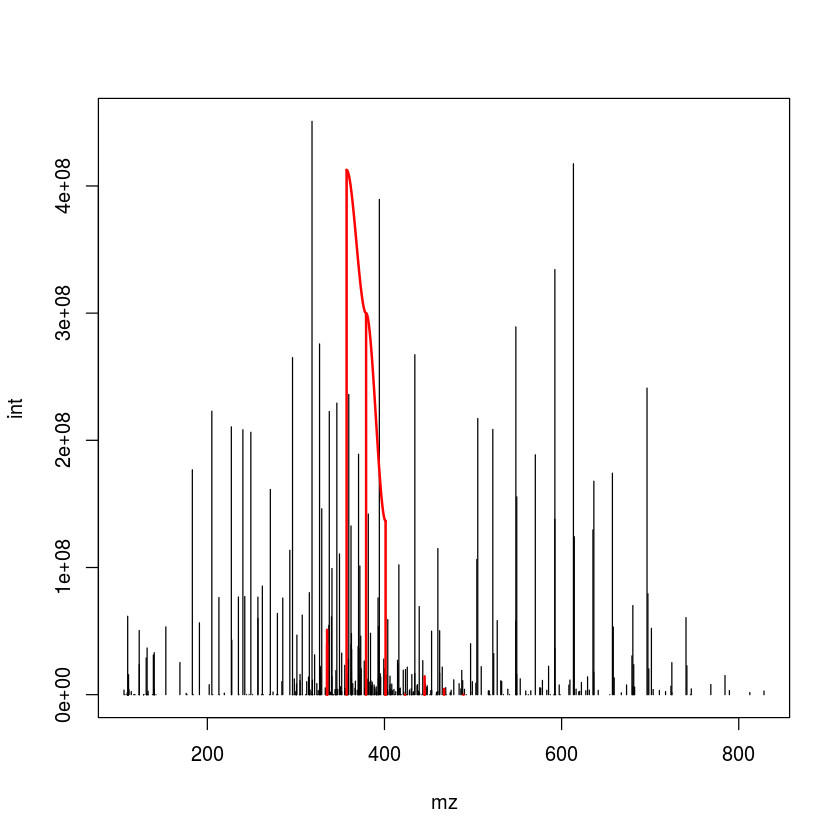

In [14]:
# Plot shape filter of charge 2 and shape filtered

# connected peaks detected by KMD
comp <- output$conn
# selection of the pattern deteced by filterShape
filt <- output$filt

y <- vec[as.numeric(comp[[3]])[filt[[3]]],3]
x <- vec[as.numeric(comp[[3]])[filt[[3]]],1]

# trick to subselect 'zoom in the graph'
mxy <- max(y)+0.1*max(y)

plot(vec[vec[,3]<mxy,-2], type='h')
points(vec[as.numeric(comp[[3]]),-2][vec[as.numeric(comp[[3]]),3]<mxy,], type='h', col=2, lwd=2)


# Fit a polynomial curve for points of the interval
# with the pattern interval
xl <- seq(min(x),max(x), (max(x) - min(x))/1000)
lo <- loess(y~x)
lines(xl, predict(lo,xl), col='red', lwd=2)

In [15]:
feat <- read.delim("BF1637_1_5_diluted_GG1_01_37572.csv", skip=5, header=FALSE)
cnames <- read.delim("BF1637_1_5_diluted_GG1_01_37572.csv", skip=3, nrow=1, header=FALSE)
colnames(feat) <- as.vector(as.matrix(cnames))
feat[1:5,1:5]

#FEATURE,rt,mz,intensity,charge
FEATURE,602.951,68.99400,1404.23,0
FEATURE,614.177,72.93850,1619.03,0
FEATURE,602.951,78.00002,1738.12,0
FEATURE,607.764,78.00042,1058.20,0
FEATURE,614.177,78.99854,3425.49,0


In [16]:
vec <- feat[feat[,5]==3,c(3,2,4)]
head(vec)

,mz,rt,intensity
11719,347.9462,184.529,2944.94
12291,355.6113,112.374,5559.05
17031,470.3389,536.804,1787.70
17294,478.3485,549.090,4481.35
17571,486.0081,552.299,3074.24
17731,491.0154,550.695,21684.20


In [17]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = 'polypropylene_glycol_other_C3H6O1', 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 2, 
    connection_filter = TRUE,
    filterShape=TRUE,
    fractionBase=3
)

In [18]:
output

NULL